## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusion](#rConclusion)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, the goal is to understand the results of an A/B test run by an e-commerce website.  Current project aims to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure we get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  ** Then use the dataframe to answer the questions in Quiz 1.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
# Read both CSV files and mearge them
# Print out first few lines

df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('landing_page == "new_page" & group != "treatment"').group.count()\
+ df.query('landing_page == "old_page" & group == "treatment"').group.count()\

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store the new dataframe in **df2**.

In [8]:
df2 = df.drop(df[(df.landing_page == "new_page") & (df.group != "treatment")].index)
df2 = df2.drop(df[(df.landing_page == "old_page") & (df.group != "control")].index)


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated('user_id')].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep our dataframe as **df2**.

In [13]:
df2.drop(df2.index[1947], inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"').group.count() / df2.group.count()

0.50006194422266881

e. Consider the results from a. through d. above, and explain below whether there is sufficient evidence to say that the new treatment page leads to more conversions.

**Answer.** According to the result, the percentage of new and old pages are in a 50% versus 50% relationship. Considering the converting ratio for new treatment and control are 11.88% and 12.04%, respectively, it seems that the new treatment page leads to less conversions. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  We can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer**

$ H_0: P_{new} - P_{old} \leq 0$

$ H_1: P_{new} - P_{old} > 0$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
df2.converted.mean()

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
df2.converted.mean()

0.11959708724499628

c. What is $n_{new}$?

In [20]:
df2.query('landing_page == "new_page"').converted.count()

145310

d. What is $n_{old}$?

In [21]:
df2.query('landing_page == "old_page"').converted.count()

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_samp = df2.sample(df2.shape[0], replace=True)

new_page_converted = new_samp.query('landing_page == "new_page"').converted.mean()


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_samp = df2.sample(df2.shape[0], replace=True)

old_page_converted = new_samp.query('landing_page == "old_page"').converted.mean()

g. Find $p_{new}$ - $p_{old}$ for our simulated values from part (e) and (f).

In [24]:
new_page_converted - old_page_converted

-0.00390344202951895

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one we calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
p_diffs = []

for _ in range(10000):
    samp = df2.sample(df2.shape[0], replace=True)
    p_diffs.append(samp.query('landing_page == "new_page"').converted.mean() -\
                   samp.query('landing_page == "old_page"').converted.mean())



i. Plot a histogram of the **p_diffs**.  Does this plot look like what we expected?  Use the matching problem in the classroom to assure we fully understand what was computed here.

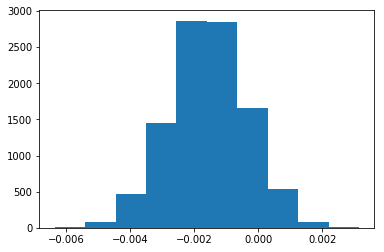

In [26]:
# Convert to numpy array
p_diffs = np.array(p_diffs)

# Plot sampling distribution
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?


0.90200000000000002

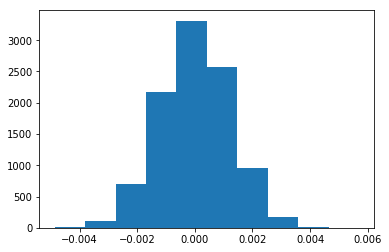

In [27]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, np.std(p_diffs), p_diffs.size)

# Find the difference of converted ratio of new page relative to old page in ab_data.csv
p_null = df2.query('landing_page == "new_page"').converted.mean() -\
df2.query('landing_page == "old_page"').converted.mean()

# Plot the null distribution
plt.hist(null_vals);

(null_vals > p_null).mean()


> The proportion of the **p_diffs** are smaller or equal than the actual difference observed in **ab_data.csv**, as the p-value here is much bigger than Type I error rate which is 5%.

k. In words, explain what we just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer.** The p-value for p_diffs that are greater than the actual difference observed in ab_data.csv is calculated. The definition of a p-value is the probability of observing the statistic (or one more extreme in favor of the alternative) if the null hypothesis is true. If the p-value is higher than Type I error rate which is 5% in current setting, then there is no satistical difference bwtween new and old pages, vice versa.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"').converted.sum()
convert_new = df2.query('landing_page == "new_page"').converted.sum()
n_old = df2.query('landing_page == "old_page"').converted.count()
n_new = df2.query('landing_page == "new_page"').converted.count()

/Users/shilinli/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute our test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [30]:
from scipy.stats import norm

# norm.cdf(z_score) tells us how significant our z-score is
# norm.ppf(1-(0.05/2)) tells us what our critical value at 95% confidence is

norm.cdf(z_score), norm.ppf(1-(0.05/2))


(0.90505831275902449, 1.959963984540054)

n. What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer.** The z-score and p-value are 1.32 and 0.19 respectively. As z-score is lower than critical value of 1.96, thus we we fail to reject the null hypothesis that the conversion rates of new page is equal to or less than than new page. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should we be performing in this case?

**Answer.** Dummy variables should be performing in this case to add categorical variables into Logistic Regression Model.

b. The goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df3 = df2.copy()
df3['intercept'] = 1
ab_page = []
for i in df3.group:
    if i == 'treatment':
        ab_page.append(1)
    else:
        ab_page.append(0)
        
df3['ab_page'] = ab_page
df3 = df3.join(pd.get_dummies(df3.landing_page))

c. Use **statsmodels** to import our regression model.  Instantiate the model, and fit the model using the two columns we created in part **b.** to predict whether or not an individual converts.

In [32]:
logit_mod = sm.Logit(df3.converted, df3[['intercept', 'ab_page']])
result = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [33]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1


d. Provide the summary of our model below, and use it as necessary to answer the following questions.

In [34]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:               8.077e-06
Time:                        12:55:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value we found in **Part II**?<br><br>  

**Answer.** Part II is a one-sided test and oncerned with which is "greater than". Part III is a two-sided test where we are concerned if there is a difference in either direction ("greater than or less than"). We care about one of the tails so we divide 0.19 by 2 to get 0.095. So this give us the absolute proportion left on each tail. The left-side tail associates with "less than", "greater than" is **1 - (0.19/2) = 0.905**, which is also the p-value of part II test. Hereby, we have explained why they are two different tests and how they are associated with each other.

f. Now, we are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into our regression model.  Are there any disadvantages to adding additional terms into our regression model?

**Answer.** It is good to consider other factors to add into this regression mode, that might influence whether or not an individual converts. Doing so would make the mode more precisely to determine if null hypothesis is accepted or rejected, which helps decision making regarding whether or not launching the new page. However, adding additional terms into the regression mode might affect the p-value of other variables.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. We will need to read in the **countries.csv** dataset and merge together our datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion? Provide the statistical output as well as a written response to answer this question.

In [35]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0


In [36]:
### Create the necessary dummy variables
df_new['intercept'] =1
df_new = df_new.join(pd.get_dummies(df_new.country))
df_new = df_new.join(pd.get_dummies(df_new.landing_page))

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and our conclusions based on the results.

In [37]:
### Fit the Linear Model And Obtain the Results
logit_mod2 = sm.Logit(df_new.converted, df_new[['intercept', 'CA', 'US', 'new_page']])
result2 = logit_mod2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366101
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290598
Model:                          Logit   Df Residuals:                   290594
Method:                           MLE   Df Model:                            3
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:               2.336e-05
Time:                        12:55:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1740
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9793      0.013   -155.412      0.000      -2.004      -1.954
CA            -0.0506      0.028     -1.784      0.075      -0.106       0.005
US            -0.0100      0.013     -0.749      0.454      -0.036       0.016
new_page      -0.0151      0.011     -1.316      0.188      -0.037       0.007
==============================================================================
"""

> Adding new variables of countries indeed had an impact on conversion, the p-value here is 0.188 afterwards. So, the probablity of converted ratio in new page is greater than thar in old page is **1 - (0.188/2) = 0.906**, which is slighter higher than before considering new variables.

In [38]:
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1


In [39]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices('converted ~ CA + US + new_page', df_new, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,5.003137,Intercept
1,1.140209,CA
2,1.140208,US
3,1.000006,new_page


> Variance inflation factor (VIF) suggested that the multicollinearity in current mutiple regression model is not a problem, giving the default value is 10.

<a id='Conclusion'></a>

### Part IV - Conclusion


- Through comparison, there is a decreasing of conversion rates in new pages versus old ones. A/B test confirmed  new page's poorer performance, thus we don't have enough evidence to reject the null hypothesis, suggesting new pages has no advantages over old ones on conversion rates.


- We had also noticed that country did have some bearing on conversion rate, but not high enough to be  statistically significant.


- In sum, I would suggest the e-commerce company at least not to consider the current new page, but trying to figure out the reason of its poor performance in order to launch another feasible page.

In [40]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_A-B_Test_Results_20180118.ipynb'])

0